<a href="https://colab.research.google.com/github/pedrohortencio/text-generator/blob/main/Song%20Generator/Gerador_de_M%C3%BAsica_com_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall keras -y
!pip install -U keras

Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3


/usr/local/lib/python3.7/dist-packages/keras/initializers/__init__.py 

In [2]:
import os
from shutil import copyfile

path_utils = '/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py'

url_utils = 'https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/python/keras/utils/generic_utils.py'

os.remove(path_utils)

!wget  $url_utils

copyfile('/content/generic_utils.py', path_utils)

--2021-06-09 20:49:59--  https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/python/keras/utils/generic_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42150 (41K) [text/plain]
Saving to: ‘generic_utils.py’

generic_utils.py    100%[===================>]  41.16K  --.-KB/s    in 0.005s  

2021-06-09 20:49:59 (8.08 MB/s) - ‘generic_utils.py’ saved [42150/42150]



'/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py'

[Keras Self Attention](https://pypi.org/project/keras-self-attention/)

[Attention is All You Need - Paper](https://arxiv.org/abs/1706.03762)

In [3]:
!pip install keras-self-attention
from tensorflow import keras
from keras_self_attention import SeqSelfAttention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.49.0-cp37-none-any.whl size=19468 sha256=622508b595ccaa67eb9e1edf2efc854f40fed08b0b63d8c3354bb4c31f1f83c2
  Stored in directory: /root/.cache/pip/wheels/6f/9d/c5/26693a5092d9313daeae94db04818fc0a2b7a48ea381989f34
Successfully built keras-self-attention


In [4]:
url = 'https://raw.githubusercontent.com/thushv89/attention_keras/322a16ee147122026b63305aaa5e899d9e5de883/src/layers/attention.py'
!wget $url

from attention import AttentionLayer

--2021-06-09 20:50:04--  https://raw.githubusercontent.com/thushv89/attention_keras/322a16ee147122026b63305aaa5e899d9e5de883/src/layers/attention.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4645 (4.5K) [text/plain]
Saving to: ‘attention.py’

attention.py        100%[===================>]   4.54K  --.-KB/s    in 0s      

2021-06-09 20:50:05 (60.3 MB/s) - ‘attention.py’ saved [4645/4645]



In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GRU, Attention, Input, Concatenate, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


In [6]:
#datasets e suas urls de arquivos no github
datasets_url = [('sertanejo','https://github.com/joaopaulopresa/nlp_mix/raw/main/RUBvuGiuSc.zip')
                ,('mpb','https://github.com/joaopaulopresa/nlp_mix/raw/main/7w1jnEycYJ.zip')
                ,('gospel', 'https://github.com/joaopaulopresa/nlp_mix/raw/main/SUShLtSOHp.zip')
]

In [7]:
#baixando os datasets descompactando na pasta datasets
from pathlib import Path
data_sets_path = '/content/datasets'
Path(data_sets_path).mkdir(parents=True, exist_ok=True)
for dataset,url in datasets_url:
  print('baixado dataset ',dataset)
  zipfile = url.split('/')[-1]
  !wget $url
  !unzip $zipfile -d /content/datasets


baixado dataset  sertanejo
--2021-06-09 20:50:05--  https://github.com/joaopaulopresa/nlp_mix/raw/main/RUBvuGiuSc.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/joaopaulopresa/nlp_mix/main/RUBvuGiuSc.zip [following]
--2021-06-09 20:50:05--  https://raw.githubusercontent.com/joaopaulopresa/nlp_mix/main/RUBvuGiuSc.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15581475 (15M) [application/zip]
Saving to: ‘RUBvuGiuSc.zip’

RUBvuGiuSc.zip      100%[===================>]  14.86M  69.4MB/s    in 0.2s    

2021-06-09 20:50:06 (69.4 MB/s) - ‘RUBvuGiuSc.zip’ saved [15581475/15581475]

Archiv

In [8]:
#datasets = {'mpb':'/content/datasets/dataset_mpb.csv',
#            'sertanejo':'/content/datasets/dataset_sertanejo.csv',
#            'gospel':'/content/datasets/dataset_gospel.csv'}
datasets = {'sertanejo':'/content/datasets/dataset_sertanejo.csv'}

In [9]:
import pandas as pd
import numpy as np

def get_estrofes_sequences(df,estrofe_formas):
  result = []
  #filtra pelas formas de estrofes
  if len(estrofe_formas) > 0:
    df = df.loc[df.estrofes_forma.apply(lambda x: x in estrofe_formas)]
  musicas = df['musica'].values
  for m in musicas:
    #cada estrofe está entre um <p> </p>
    #removendo as tags <p>
    m = m.replace('<p>','')
    m = m.replace('<div>','')
    m = m.replace('</div>','')
    #pegando array de estrofes da musica
    estrofes = m.split('</p>')[:-1] #removendo elemento null do array da ultima estrofe
    #ajustar separador de versos usar própria tag <br> adicionado espaço entre ela e as palavras
    for e in estrofes:
      estrofe = e.replace('<br>', ' <br> ').strip()
      result.append(estrofe)
  return result

def get_artista(df,artista_l):
  result = []
  #filtra pelo artista
  if len(artista_l) > 0:
    df = df.loc[df.artista.apply(lambda x: x in artista_l)]
  musicas = df['musica'].values
  for m in musicas:
    #cada estrofe está entre um <p> </p>
    #removendo as tags <p>
    m = m.replace('<p>','')
    m = m.replace('<div>','')
    m = m.replace('</div>','')
    #pegando array de estrofes da musica
    estrofes = m.split('</p>')[:-1] #removendo elemento null do array da ultima estrofe
    #ajustar separador de versos usar própria tag <br> adicionado espaço entre ela e as palavras
    for e in estrofes:
      estrofe = e.replace('<br>', ' <br> ').strip()
      result.append(estrofe)
  return result



In [10]:
import pandas as pd
import numpy as np
#possíeis valores mpb, sertanejo ou gospel
#dataset = 'gospel'
dataset = 'sertanejo'
df = pd.read_csv(datasets[dataset])
print('colunas :',list(df.columns))
print('tamanho: ',len(df.values.tolist()))
print('head:\n')
countt = 0
for v in df.values.tolist():
      if countt < 3:
        print (v)
      countt += 1
print(df.head())

colunas : ['artista', 'titulo', 'musica', 'autor', 'estrofes', 'estrofes_forma']
tamanho:  54906
head:

['Gusttavo Lima', '10 Anos', ' <p>Fala<br>Seria covardia ir embora sem dizer por quê<br>Existem tantas páginas dessa história pra escrever<br>Não venha inventar um fim</p><p>Fala<br>Depois de tanto tempo juntos, você vai deixar no ar?<br>Será que pensa que agindo assim o amor irá mudar?<br>Há tanto ainda pra viver, tudo é nada sem você</p><p>Nosso amor não acabou, e ainda digo mais<br>Vou te fazer lembrar de tudo que me prometeu há 10 anos atrás<br>Amor e muito mais<br>Tô pagando pra ver se você é capaz de me esquecer</p></div><p>Nosso amor não acabou, e ainda digo mais<br>Vou te fazer lembrar de tudo que me prometeu há 10 anos atrás<br>Amor e muito mais<br>Tô pagando pra ver se você é capaz de me esquecer</p><p>Fala<br>Seria covardia ir embora sem dizer por quê<br>Existem tantas páginas dessa história pra escrever<br>Não venha inventar um fim</p><p>Fala<br>Depois de tanto tempo junt

In [11]:
#principais formas de estrofe do dataset
l = df['estrofes_forma'].values
formas_count = pd.Series(l).value_counts()
print(formas_count[:20])
#cantores do dataset
l = df['artista'].values
formas_count = pd.Series(l).value_counts()
print(formas_count[:40])

irregular                                                                                    2656
quarteto-quarteto-quarteto-quarteto                                                          1779
quarteto-quarteto-quarteto-quarteto-quarteto-quarteto                                        1483
quarteto-quarteto-quarteto                                                                   1273
quarteto-quarteto-quarteto-quarteto-quarteto                                                 1075
quarteto-quarteto-quarteto-quarteto-quarteto-quarteto-quarteto-quarteto                       889
oitava-oitava-oitava                                                                          441
oitava-oitava-oitava-oitava                                                                   395
quarteto-quarteto-quarteto-quarteto-quarteto-quarteto-quarteto                                386
quarteto-quarteto-quarteto-quarteto-quarteto-quarteto-quarteto-quarteto-quarteto-quarteto     360
oitava-quarteto-oita

In [12]:
#criando sequencias
#definindo filtro de formas (nesse caso o modelo aprenderá a escrever estrofes na forma de quarteto)
formas = ['quarteto-quarteto-quarteto-quarteto',
          'quarteto-quarteto-quarteto-quarteto-quarteto',
          'quarteto-quarteto-quarteto-quarteto-quarteto-quarteto',
          'quarteto-quarteto-quarteto']
artistas = ['Gusttavo Lima','Luan Santana','Marília Mendonça']
#artistas = ['Marília Mendonça']
#falta criar a busca por compositores (busca com strig próxima - looks like. Ex: Pedro e buscar todas musicas com Pedro e variações no campo compositor)
compositores = [] 
#sequences_list = get_estrofes_sequences(df=df,estrofe_formas=formas)
sequences_list = get_artista(df,artistas)
print(len(sequences_list), ' sequencias de estrofes recuperadas')



5367  sequencias de estrofes recuperadas


In [13]:
#visualizando 5 primeiras sequencias
for s in sequences_list[0:5]:
  print('sequence string: ',s)
  print('estrofe:')
  print(s.replace(' <br> ','\n').strip()+'\n')

sequence string:  Fala <br> Seria covardia ir embora sem dizer por quê <br> Existem tantas páginas dessa história pra escrever <br> Não venha inventar um fim
estrofe:
Fala
Seria covardia ir embora sem dizer por quê
Existem tantas páginas dessa história pra escrever
Não venha inventar um fim

sequence string:  Fala <br> Depois de tanto tempo juntos, você vai deixar no ar? <br> Será que pensa que agindo assim o amor irá mudar? <br> Há tanto ainda pra viver, tudo é nada sem você
estrofe:
Fala
Depois de tanto tempo juntos, você vai deixar no ar?
Será que pensa que agindo assim o amor irá mudar?
Há tanto ainda pra viver, tudo é nada sem você

sequence string:  Nosso amor não acabou, e ainda digo mais <br> Vou te fazer lembrar de tudo que me prometeu há 10 anos atrás <br> Amor e muito mais <br> Tô pagando pra ver se você é capaz de me esquecer
estrofe:
Nosso amor não acabou, e ainda digo mais
Vou te fazer lembrar de tudo que me prometeu há 10 anos atrás
Amor e muito mais
Tô pagando pra ver s

In [14]:
#criando o corpus:
corpus = [s.lower() for s in sequences_list]
print('tamanho corpus: ', len(corpus))
#removendo sequencias duplicadas (artistas diferentes cantando mesma música)
corpus = list(dict.fromkeys(corpus))
print('tamanho corpus, duplicatas removidas: ', len(corpus))

tamanho corpus:  5367
tamanho corpus, duplicatas removidas:  3967


In [15]:
maxi = 100
min = 100
mean = []
for e in corpus:
  tam = len(e)
  mean.append(tam)
  if tam < min:
    min = tam
  if tam > maxi:
    maxi = tam
media = sum(mean) / len(mean) 
print(min)
print(maxi)
print(media)


1
5193
165.12578774892867


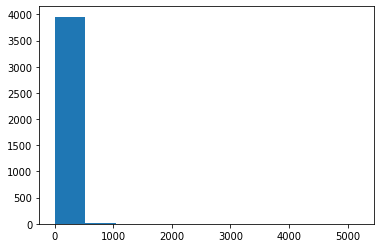

In [16]:
import matplotlib.pyplot as plt

plt.hist(mean, bins=10)
plt.show()

In [17]:
#removendo algumas sequencias por questão de memória do notebook
print('tamanho corpus: ', len(corpus))
corpus = [e for e in corpus if len(e) < 900 ]
corpus = [e for e in corpus if len(e) > 50 ]
print('tamanho corpus, sequencias pequenas e grandes removidas: ', len(corpus))

tamanho corpus:  3967
tamanho corpus, sequencias pequenas e grandes removidas:  3837


In [18]:
#visualizando 5 primeiras sequencias
for s in corpus[0:5]:
  print('sequence string: ',s)
  print('estrofe:')
  print(s.replace(' <br> ','\n').strip()+'\n')

sequence string:  fala <br> seria covardia ir embora sem dizer por quê <br> existem tantas páginas dessa história pra escrever <br> não venha inventar um fim
estrofe:
fala
seria covardia ir embora sem dizer por quê
existem tantas páginas dessa história pra escrever
não venha inventar um fim

sequence string:  fala <br> depois de tanto tempo juntos, você vai deixar no ar? <br> será que pensa que agindo assim o amor irá mudar? <br> há tanto ainda pra viver, tudo é nada sem você
estrofe:
fala
depois de tanto tempo juntos, você vai deixar no ar?
será que pensa que agindo assim o amor irá mudar?
há tanto ainda pra viver, tudo é nada sem você

sequence string:  nosso amor não acabou, e ainda digo mais <br> vou te fazer lembrar de tudo que me prometeu há 10 anos atrás <br> amor e muito mais <br> tô pagando pra ver se você é capaz de me esquecer
estrofe:
nosso amor não acabou, e ainda digo mais
vou te fazer lembrar de tudo que me prometeu há 10 anos atrás
amor e muito mais
tô pagando pra ver s

In [19]:
#criando o tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
filters_ = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t'  # removido < > para manter o token <br> que separa os versos nas sequencias de estrofes
tokenizer = Tokenizer(filters=filters_)
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
print('indíces dos tokens:',tokenizer.word_index)
print('total tokens:',total_words)



indíces dos tokens: {'<br>': 1, 'que': 2, 'eu': 3, 'não': 4, 'o': 5, 'de': 6, 'e': 7, 'você': 8, 'a': 9, 'me': 10, 'é': 11, 'pra': 12, 'te': 13, 'se': 14, 'amor': 15, 'um': 16, 'meu': 17, 'vou': 18, 'seu': 19, 'vai': 20, 'mais': 21, 'do': 22, 'no': 23, 'em': 24, 'só': 25, 'por': 26, 'com': 27, 'mas': 28, 'na': 29, 'tem': 30, 'tô': 31, 'minha': 32, 'coração': 33, 'uma': 34, 'sem': 35, 'mim': 36, 'tudo': 37, 'já': 38, 'da': 39, 'quero': 40, 'tá': 41, 'quando': 42, 'quem': 43, 'gente': 44, 'ela': 45, 'sei': 46, 'sua': 47, 'foi': 48, 'ser': 49, 'vida': 50, 'agora': 51, 'esse': 52, 'aqui': 53, 'amar': 54, 'ver': 55, 'faz': 56, 'bem': 57, 'sou': 58, 'como': 59, 'dia': 60, 'vem': 61, 'assim': 62, 'nem': 63, 'quer': 64, 'tão': 65, 'tempo': 66, 'os': 67, 'sempre': 68, 'ter': 69, 'hoje': 70, 'fazer': 71, 'saudade': 72, 'até': 73, 'mundo': 74, 'nosso': 75, 'vez': 76, 'ele': 77, 'essa': 78, 'as': 79, 'ficar': 80, 'nada': 81, 'oh': 82, 'sabe': 83, 'aí': 84, 'nunca': 85, 'está': 86, 'nós': 87, 'noit

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np 
#criando as sequencias e seus respectivos labels
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
print('tamanho máximo de sequencia: ' , max_sequence_len)
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)
print (xs[55], ys[55])
print (len(xs))

tamanho máximo de sequencia:  152
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0  213    1  115    6  112   66  689    8
   20  164   23  391    1  152    2  488    2 4131   62    5   15 1141
  283    1  228  112   93   12  116   37   11   81   35] [0. 0. 0. ... 0. 0. 0.]
125751


In [21]:
ys

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
xs.shape

(125751, 151)

In [23]:
ys.shape

(125751, 6760)

In [24]:
total_words

6760

In [25]:
#Criando o modelo
"""from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
#definindo parâmetros de treinamento
EMBEDDING_SIZE = 300
LSTM_UNITS = 256
LEARNING_RATE = 0.01
#construíndo modelo 

model = Sequential()
model.add(Embedding(total_words, EMBEDDING_SIZE, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(LSTM_UNITS)))
model.add(Dense(total_words, activation='softmax'))

adam = Adam(lr=LEARNING_RATE)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())"""

"from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.optimizers import Adam\n#definindo parâmetros de treinamento\nEMBEDDING_SIZE = 300\nLSTM_UNITS = 256\nLEARNING_RATE = 0.01\n#construíndo modelo \n\nmodel = Sequential()\nmodel.add(Embedding(total_words, EMBEDDING_SIZE, input_length=max_sequence_len-1))\nmodel.add(Bidirectional(LSTM(LSTM_UNITS)))\nmodel.add(Dense(total_words, activation='softmax'))\n\nadam = Adam(lr=LEARNING_RATE)\n\nmodel.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])\nprint(model.summary())"

In [26]:
#Criando o modelo
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

#definindo parâmetros de treinamento
EMBEDDING_SIZE = 300
LSTM_UNITS = 128
LEARNING_RATE = 0.01


model = Sequential()
model.add(Embedding(total_words, EMBEDDING_SIZE, input_length=max_sequence_len-1, mask_zero=True))

model.add(BatchNormalization())
model.add(Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)))
model.add(SeqSelfAttention(attention_width=25,  attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL, attention_activation='sigmoid'))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())

#model.add(Dense(int(total_words/2), activation='relu'))
#model.add(LSTM(int(LSTM_UNITS/2)))

model.add(Dense(total_words, activation='softmax'))

adam = Adam()

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 151, 300)          2028000   
_________________________________________________________________
batch_normalization (BatchNo (None, 151, 300)          1200      
_________________________________________________________________
bidirectional (Bidirectional (None, 151, 256)          439296    
_________________________________________________________________
seq_self_attention (SeqSelfA (None, 151, 256)          65537     
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense (Dense)                (None, 6760)              1

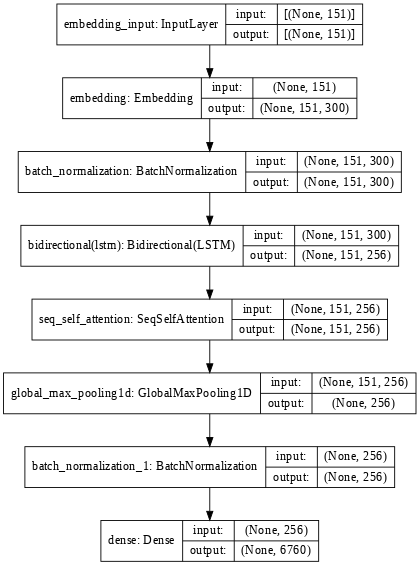

In [28]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 151, 300)          2028000   
_________________________________________________________________
batch_normalization (BatchNo (None, 151, 300)          1200      
_________________________________________________________________
bidirectional (Bidirectional (None, 151, 256)          439296    
_________________________________________________________________
seq_self_attention (SeqSelfA (None, 151, 256)          65537     
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense (Dense)                (None, 6760)              1

In [30]:
#limpando memória
import gc
gc.collect()

32875

In [31]:
#Treinando o modelo
#definindo parâmetros
EPOCHS = 15
STEPS_PER_EPOCH = 150
history = model.fit(xs, ys, epochs=EPOCHS, verbose=1, steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/15
150/150 [==============================] - 137s 849ms/step - loss: 7.2953 - accuracy: 0.1236
Epoch 2/15
150/150 [==============================] - 125s 836ms/step - loss: 4.8203 - accuracy: 0.2120
Epoch 3/15
150/150 [==============================] - 125s 832ms/step - loss: 3.8586 - accuracy: 0.2824
Epoch 4/15
150/150 [==============================] - 125s 832ms/step - loss: 3.1362 - accuracy: 0.3665
Epoch 5/15
150/150 [==============================] - 124s 829ms/step - loss: 2.5308 - accuracy: 0.4575
Epoch 6/15
150/150 [==============================] - 124s 829ms/step - loss: 2.0425 - accuracy: 0.5467
Epoch 7/15
150/150 [==============================] - 124s 826ms/step - loss: 1.6612 - accuracy: 0.6208
Epoch 8/15
150/150 [==============================] - 124s 827ms/step - loss: 1.3652 - accuracy: 0.6840
Epoch 9/15
150/150 [==============================] - 124s 824ms/step - loss: 1.1325 - accuracy: 0.7347
Epoch 10/15
150/150 [==============================] - 125s 831m

In [39]:
model.save('/model')
!zip -r /content/model-09062021.zip /model
model.save_weights('treino-09062021.h5')

INFO:tensorflow:Assets written to: /model/assets


INFO:tensorflow:Assets written to: /model/assets


updating: model/ (stored 0%)
updating: model/keras_metadata.pb (deflated 90%)
updating: model/variables/ (stored 0%)
updating: model/variables/variables.index (deflated 67%)
updating: model/variables/variables.data-00000-of-00001 (deflated 8%)
updating: model/saved_model.pb (deflated 90%)
updating: model/assets/ (stored 0%)


In [ ]:
### Restaurar o modelo:

#keras.models.load_model(model_path, custom_objects=SeqSelfAttention.get_custom_objects())

In [33]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

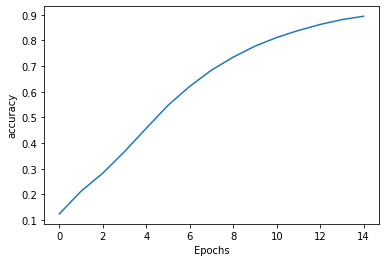

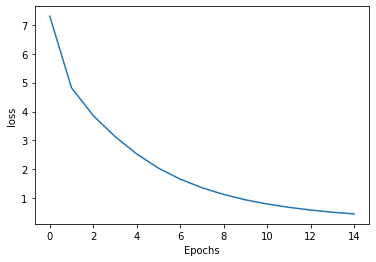

In [34]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [48]:
#forneça um texto de entrada e quantas palavras vãão ser preditas a partir dele
#seed_text = "Você é minha vida"
#seed_text = "Amor da minha vida"
#seed_text = "Já vi que você vai sair E a sequência eu já sei"
#seed_text = "Barzinho outra vez"
#seed_text = "Disk-recaída, bateu carência liga"
#seed_text = "Agora não chega mais nenhuma notificação sua"
#seed_text = "Você não é nada além de uma causa perdida"
#seed_text = "Vou tentar te esquecer"
#seed_text = "Seguir seus passos já não posso mais"
seed_text = "Nunca me enxerguei em outra pessoa"

next_words = 180
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
#como o modelo prevê sequencias de versos em quartetos separados por <br> vamos substituir o token por newline e imprimir os versos gerados
versos = seed_text.split(' <br> ')
counter = -1
value = 4
print('\n Musica: ',versos[0],'\n')
for v in versos[1:]:
	print(v.capitalize())
	counter = counter + 1
	if counter == value:
		print('\n')
		counter = 0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



 Musica:  Nunca me enxerguei em outra pessoa 

Eu ia me amar assim
Você tá me ligando pra sofrer
E agora eu já chorei por amar
Amar outra vez assim eu não ia amar
Amar assim ou me leva de uma vez


Mas amar outra vez eu não sei amar
Mas pra desistir de nada
Mas é uma hora de me amar
Só quer amar e assim voltar de mim


Se me entregar agora assim
É só um amor bandido e assim
Amar você vai embora agora eu sei
Se amar é hora vou voltar atrás


Amor por que me dá um de amor
Com outra vez vai dizer que já tem meu coração
Então já não te mereço amor assim
Sou só um amor assim eu vou embora


Então diz que já me faz parte da paixão
Com calma esse amor vou te amar
Calma também vou deixar só sofrer
Bem com calma que me faz sofrer


Então gritando você com esse amor perigoso <br>


In [36]:
### Textos Gerados Anteriormente:

""" Musica:  Amor da minha vida por você 

Eu não quero nada
Eu tô nem quero só você
Tô nos olhos de te ver
Tô nem aí eu quero só você
Se for pra mim não quero assim


Quero esse amor não quero é só você
Eu quero é só você
Que cê não sabe de mim
E nos olhos de mim é que te ver


Eu tô nem mudo pra não te ver
Tô nem conto de fadas com esse cara é só você
Vou te contar que raiva de te amar
Que eu te amo tanto é demais é só você


Vou te falar só agora eu vou te amar
Mais vou te contar pois é tudo
Tanto que mais é errado e não mais ter medo de te esquecer
Agora você vai casar mim


Se você não for insegurança nunca mais
O amo você
Você foi embora e levou minha vida
Se você me amou nunca for insegurança


Foi demais o"""

#################################################

"""Musica:  Você é minha vida o que eu sinto mais o seu 

É saber de tudo o que você me faz
Agora é tão bom pra saber
As estrelas como faz a moda
São tantas coisas que eu nem sei o que nem queria
Acho que agora deve ter depressa aqui é o mundo


Como se eu escrevo é o que eu sinto
Tô de você pra mim não é capaz de te esquecer
Com outra vez eu vou sair os meus sonhos
Acho que hoje você não é bom demais


Vou ter você pra valer o bom voltar
Vou ter você pra mim não vai mais voltar
Tenho que hoje tenho asas
De hoje vou voltar atrás de outra vez


Hoje vou ter você pra voltar de volta
Vou atrás de outra vez
O que vou pedir pra você voltar de volta
Vou voltar atrás de quem te machucar


Pede pra alguém que me possa
Solidão vou te pedir de novo
Assim não vou"""

##############################

""" Musica:  Agora não chega mais nenhuma notificação sua 

Que arrasta pra conversar
Tão vazia no final de fora
Eu tô aqui pra você
Eu tô morrendo de paixão
Mas não quero mais saber


Se você está tão perto
Tô de mim
Se foi embora se hoje está aqui
Então não fique comigo


Tô falando sério
Não preciso de amor
Foi demais a minha vida
Já não tem nada


Não quero dinheiro
Se você não engana
Fique aí sozinha
Por amor não sou isso tudo


Se você não quiser de mim
Para mim não sou isso
Não vai se enganar
Não sou o amor é tudo isso que eu vivo


A gente não se engana
Não me engana
Não fala que você me deixa falando amor
Então você não se engana


Não adianta voltar de novo o mesmo
Se for tanto assim
Se me engana
Não adianta voltar de outra saída


Se me deixa falando sério
Saiba que"""

###############################

"""Musica:  Você não é nada além de uma causa perdida 

E não vale mais nada mais uma dor
Agora não é mais uma dor que só quer um passado
Mais uma briga mas não pode ir embora
Um coração estou pagando a dois
Um de uma dor da sua vida


E dar um sentimento é passado
Não é mais uma vez de amor
Um erro é mais que um bom passado
Agora estou com o cara de bobo a dois


Fala que tá difícil de amar um coração
Depois de tudo isso é um passado
Com o nome é tudo é só um dono
De tudo isso que a gente passou


Não é covardia mais é um bom amor
É covardia minha festa é um esqueço um sentimento sem ninho
Não se liberta o amor nunca vou te ver
São volta só vem e se tiver dor


Se não for pecado quem é a culpa
Se o amor é bom é fiel esse amor fiel
Às vezes não sabe de"""

#########################################

"""Musica:  Vou tentar te esquecer 

Os meus sonhos não quero mais
Posso me tirar dessa paixão
Eu não quero mais não
Se tiver seus paixão
Vai ser o meu coração


Não vai ser mais forte
Ah eu quero só você
Seu amor não quero paixão
Não quero dinheiro não


Se eu tiver um jeito de sofrer
Ah porque não quero esse amor não vai ser melhor não
Eu quero esse amor não vai ser o meu amor
Não quero não tem nem dinheiro não


Se você me quer do mundo
Deixa mesmo de ser capaz de você
Do amor que
Deixa eu viver paixão


Não dá prazer
Mas você não dá mais
Eu tô de paixão
Então você não dá tempo


Você quis ficar do meu coração
Você nem fica tudo triste
Você se acha que me quis
Esse amor não pode ter de paixão


Mas se acha que me deixa dessa vida
Se você me jogou fora"""

#####################

"""Musica:  Seguir seus passos já não posso mais 

Que ele foi em vão e ele foi
E ele que me vi assim
Foi que ele me fez de amor
E percebi que era só um dia ele não vai mais
Que foi só um mês que já não te quis


Eu percebi que te vi
Te vi meu coração não te encontrei normal
Volta de tão sem ele não quis me ouvir
Foi só um dia ele não quis me percebi


Não sabia só de um mal que te vi
Te encontrei um de volta agora foi me tão mal
Não vi esse amor não foi em volta
Te amo nem adeus e percebi


Agora percebi que eu vou te chegando
Agora não sabia nem de um amor
Passou isso era minha amizade
E passou pra mim não morreu


Não consigo te esquecer
O amor amo você nunca teve fim
Foi somente pra mim
Linda desse amor nunca se esqueça


Amor nunca se for insegurança demais"""

